In [17]:
import pandas as pd

# Load full index data
df = pd.read_csv("../data/BTC_chan_analysis.csv")

# Filter for sh000016 and immediately copy to avoid SettingWithCopyWarning
# df_50 = df.loc[df['index_code'] == 'sh000016'].copy()
df_50 = df
print('Loaded rows:', len(df), 'Filtered rows:', len(df_50))
print(df_50.head())
# get all columns names

Loaded rows: 1827 Filtered rows: 1827
  index_code        date          open          high           low  \
0        BTC  2020-10-30  13546.522461  13651.516602  13136.198242   
1        BTC  2020-10-31  13780.995117  14028.213867  13457.530273   
2        BTC  2020-11-01  13737.109375  13862.033203  13628.377930   
3        BTC  2020-11-02  13550.489258  13808.323242  13243.160156   
4        BTC  2020-11-03  13950.300781  13984.981445  13325.441406   

          close       volume  
0  13437.874023  30581485201  
1  13546.532227  30306464719  
2  13780.995117  24453857900  
3  13737.032227  30771455468  
4  13550.451172  29869951617  


In [18]:
from ChanAnalysis import ChanAnalysis
# Initialize ChanAnalysis AFTER class definition
# Prepare df_50
if not pd.api.types.is_datetime64_any_dtype(df_50['date']):
    df_50['date'] = pd.to_datetime(df_50['date'], errors='coerce')

df_50 = df_50.sort_values('date').dropna(subset=['date']).reset_index(drop=True)
chan = ChanAnalysis(df_50)
print('Initialized ChanAnalysis. Original bars:', len(df_50), 'Compressed bars:', len(chan.comp_df))

Initialized ChanAnalysis. Original bars: 1827 Compressed bars: 1078


In [34]:
import sys
sys.path.append('..')
from tdx_func import boduan
# Calculate boduan indicators
boduan_results = boduan(chan.comp_df)

In [38]:
# Compute fractals & strokes sequentially
fractals_initial = chan.find_fractal()
strokes_initial = chan.find_strokes(fractals_initial)
print('Initial fractals:', len(fractals_initial), 'Initial strokes:', len(strokes_initial))

chan.recompress_after_first_stroke()
fractals = chan.find_fractal()
strokes = chan.find_strokes(fractals)
# Enhance strokes list with convenience min/max for later stop reference (optional)
for s in strokes:
    s['low'] = min(s['start_price'], s['end_price'])
    s['high'] = max(s['start_price'], s['end_price'])



Initial fractals: 475 Initial strokes: 347


In [39]:

# Segments, Zhongshu and Buy/Sell points
segments = chan.find_segments(strokes)
print('Segments:', len(segments))
zhongshu = chan.find_zhongshu(strokes)
print('Zhongshu merged:', len(zhongshu))

points_basic = chan.find_buy_sell_points(segments, zhongshu)
points_adv = chan.find_advanced_buy_sell_points(segments, zhongshu, dist_threshold=0.03, tiny_penetration=0.04)
print('Basic points:', len(points_basic), 'Advanced points:', len(points_adv))

# Enrich points with reference levels for potential stop-loss logic
# For buys: ref_low = recent swing low (previous segment end_price if down) or min of previous 2 strokes lows
# For sells: ref_high analogously.
# This keeps original pattern classification but adds fields.


def _infer_reference_levels(points, segments):
    seg_map_end = {seg['end_index']: seg for seg in segments}
    # Build a lookup by index to segment containing that index (simple last containing)
    seg_by_index = {}
    for seg in segments:
        for i in range(seg['start_index'], seg['end_index']+1):
            seg_by_index[i] = seg
    enriched = []
    for p in points:
        seg_context = seg_by_index.get(p['index'])
        ref_low = None; ref_high = None
        if seg_context:
            seg_idx = segments.index(seg_context)
            # previous segment for reference
            prev_seg = segments[seg_idx-1] if seg_idx>0 else None
            if p['type']=='buy':
                # use lower of prev down segment if it was down
                if prev_seg and prev_seg['direction']=='down':
                    ref_low = min(prev_seg['start_price'], prev_seg['end_price'])
                # fallback: take min of last 2 strokes lows inside prev_seg
                if ref_low is None and prev_seg:
                    lows = []
                    for st in prev_seg['strokes']:
                        lows.append(min(st['start_price'], st['end_price']))
                    ref_low = min(lows) if lows else None
            elif p['type']=='sell':
                if prev_seg and prev_seg['direction']=='up':
                    ref_high = max(prev_seg['start_price'], prev_seg['end_price'])
                if ref_high is None and prev_seg:
                    highs = []
                    for st in prev_seg['strokes']:
                        highs.append(max(st['start_price'], st['end_price']))
                    ref_high = max(highs) if highs else None
        p_en = dict(p)
        if ref_low is not None:
            p_en['ref_low'] = ref_low
            # optional tight stop (e.g., 1.2% below)
            p_en['stop_loss'] = ref_low * 0.988
        if ref_high is not None:
            p_en['ref_high'] = ref_high
            p_en['stop_loss'] = ref_high * 1.012  # for sells: protective stop above
        enriched.append(p_en)
    return enriched

points_all_raw = points_basic + points_adv
points_all = _infer_reference_levels(points_all_raw, segments)
points_df = pd.DataFrame(points_all).sort_values('date')
print('Total unique points (enriched):', len(points_df))
points_df.head()

Segments: 173
Zhongshu merged: 65
Basic points: 91 Advanced points: 97
Total unique points (enriched): 188


,index,date,type,pattern,price,description,ref_high,stop_loss,ref_low
0,23,2020-11-22,sell,yi_mai,17671.384766,Segment reversal yi mai,19390.964844,19623.656422,NaN
91,23,2020-11-22,sell,yi_mai,17671.384766,Segment reversal yi mai,19390.964844,19623.656422,NaN
1,32,2020-12-07,buy,yi_mai,19845.974609,Segment reversal yi mai,NaN,17408.098805,17619.533203
92,32,2020-12-07,buy,yi_mai,19845.974609,Segment reversal yi mai,NaN,17408.098805,17619.533203
182,42,2020-12-11,buy,san_mai,17619.533203,San mai: Pullback near upper edge did not deep...,NaN,17408.098805,17619.533203


Subset fractals: 19, strokes: 14, segments: 6, zhongshu: 3, points: 2


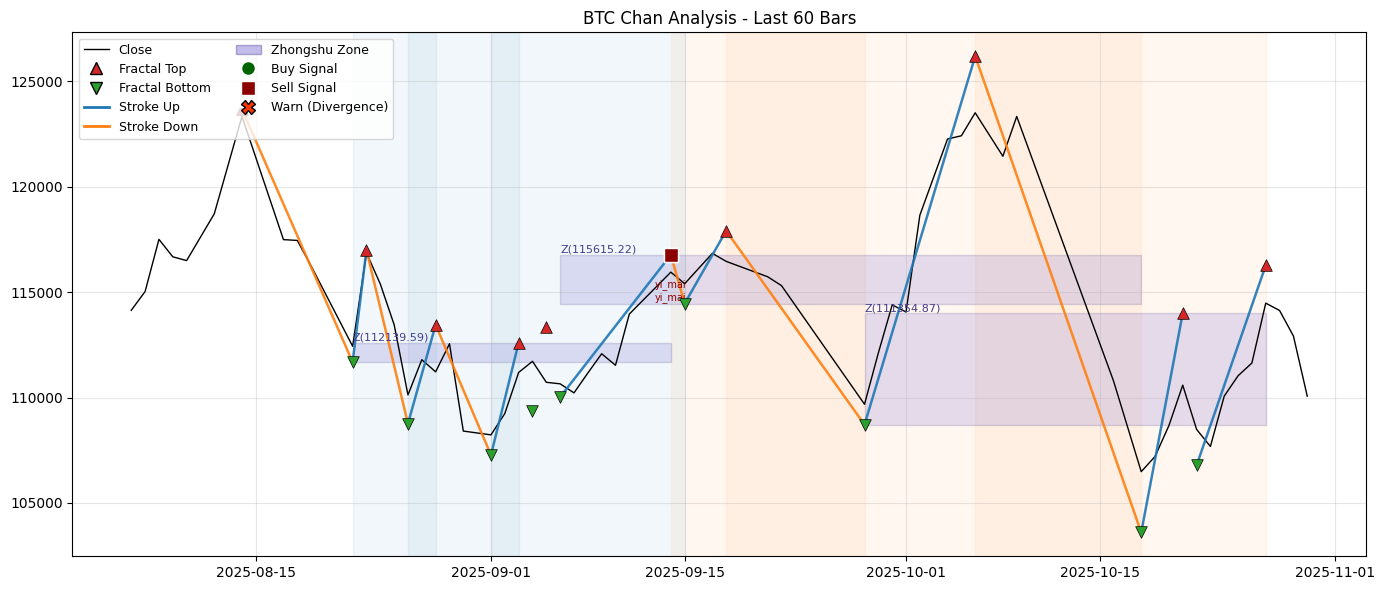

In [59]:
# Import the plotting function - reload to get the updated version
import importlib
from matplotlib import pyplot as plt
import plot_util
importlib.reload(plot_util)
from plot_util import plot_chan_analysis

# Plot configuration
# Choose either last_n (e.g., 300) or a date window (start_date, end_date)
last_n = 60  # set to None to use date range instead
start_date = None  # e.g., '2022-01-01'
end_date = None    # e.g., '2023-12-31'
text_offset_ratio = 0.01  # vertical offset for text labels as ratio of price range
stack_step_ratio = 0.005  # vertical step between stacked labels as ratio of price range

# Use the function to create the plot
fig, ax = plot_chan_analysis(
    chan=chan,
    fractals=fractals,
    strokes=strokes,
    segments=segments,
    zhongshu=zhongshu,
    points_df=points_df,
    last_n=60,  # Show last 60 bars
    title="BTC Chan Analysis - Last 60 Bars"
)

plt.show()

Subset fractals: 19, strokes: 14, segments: 6, zhongshu: 3, points: 2
Boduan data mapped: C1 valid values: 60


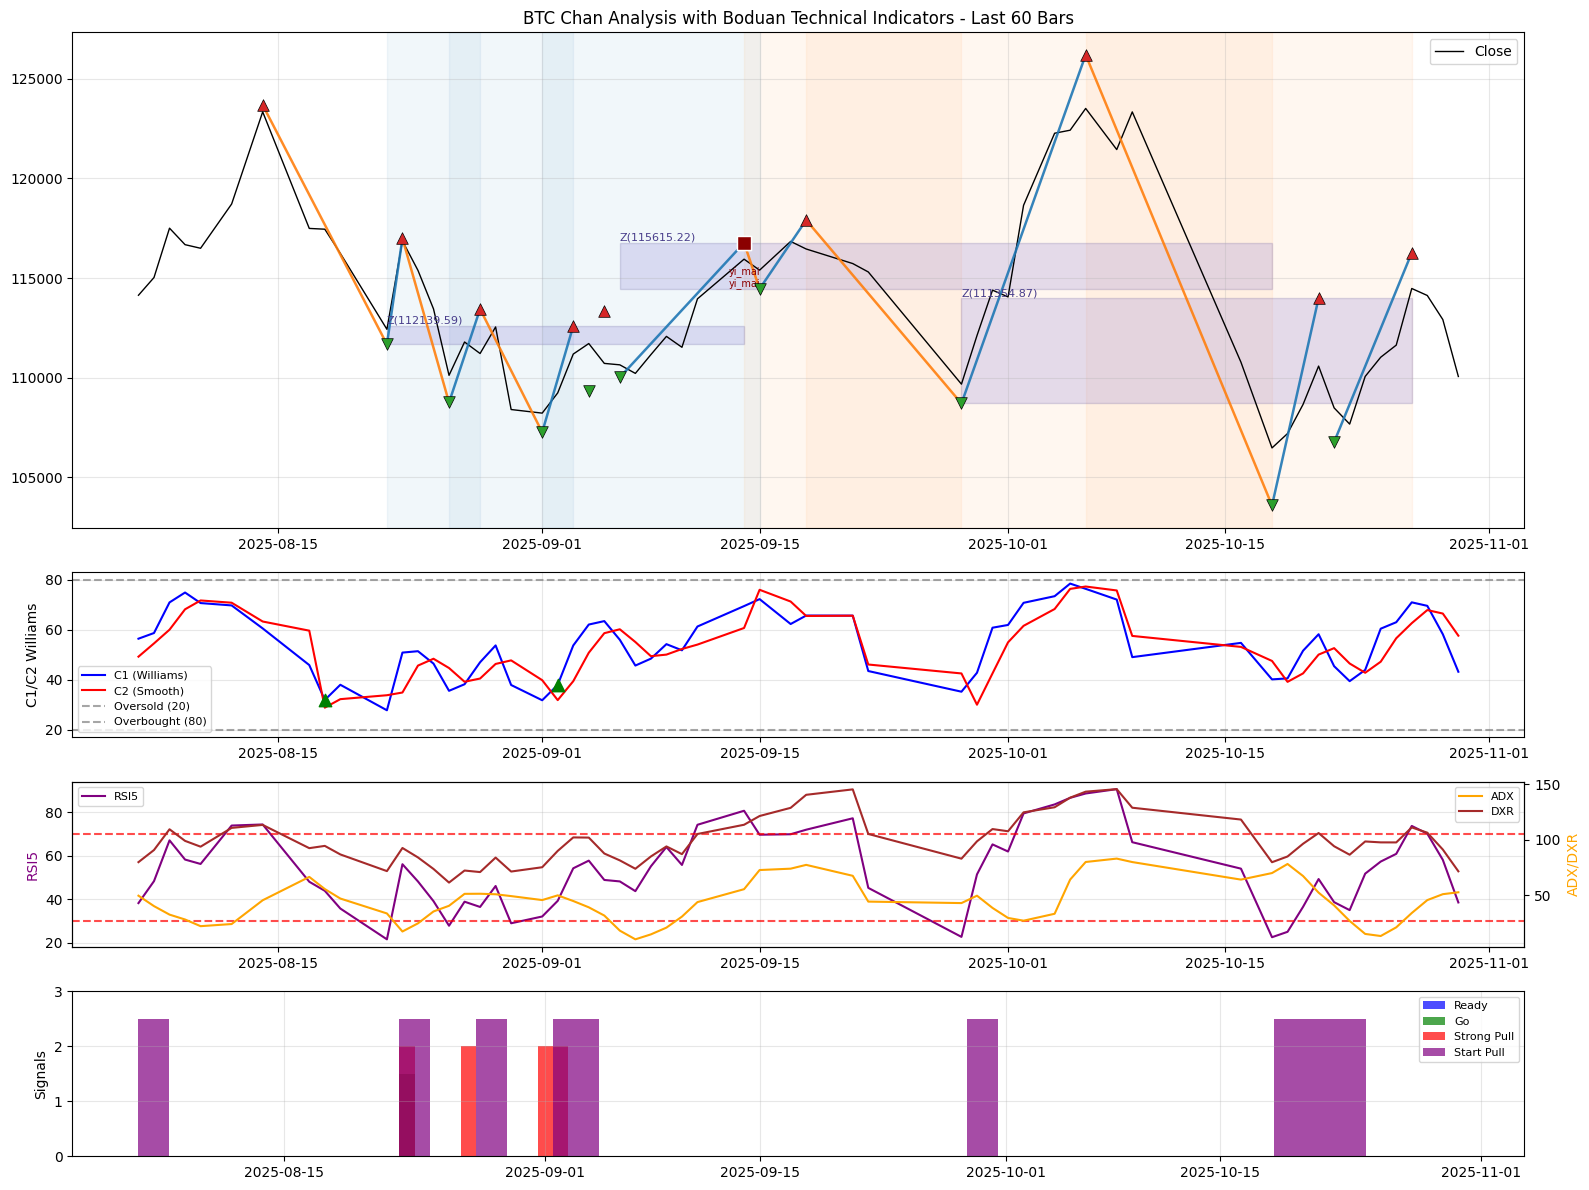

In [58]:
# Plot Chan analysis with boduan indicators using the merged function
fig, axes = plot_chan_analysis(
    chan=chan,
    fractals=fractals,
    strokes=strokes,
    segments=segments,
    zhongshu=zhongshu,
    points_df=points_df,
    boduan_results=boduan_results,  # This triggers the multi-panel layout
    last_n=60,  # Show last 60 bars
    title="BTC Chan Analysis with Boduan Technical Indicators - Last 60 Bars"
)

plt.show()

In [23]:
# Summary
print('Fractals:', len(fractals))
print('Strokes:', len(strokes))
print('Segments:', len(segments))
print('Zhongshu:', len(zhongshu))
print('Points total:', len(points_df))
if not points_df.empty:
    print(points_df.groupby(['type','pattern']).size())
# points_df.tail(10)

Fractals: 475
Strokes: 347
Segments: 173
Zhongshu: 65
Points total: 188
type  pattern
buy   er_mai      6
      san_mai     3
      yi_mai     62
sell  er_mai      6
      san_mai     3
      yi_mai     64
warn  beichi     44
dtype: int64


In [24]:
# Define atr_map before it's used for pm.current_atr_pct.
# Assumptions:
# - Price DataFrame is `df` with columns: 'high','low','close'.
# - We'll compute a standard ATR (Wilder) over a default window (e.g. 14) and then
#   convert to a percentage of close to match usage `pm.current_atr_pct`.
# - atr_map is a dict keyed by integer index (row number) mapping to ATR% value.
# If existing code later expects a different window, adjust `atr_period` below.

atr_period = 14
required_cols = {'high','low','close'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"DataFrame df missing required columns for ATR calculation: {missing}")

# True Range components
high = df['high']
low = df['low']
close_prev = df['close'].shift(1)
tr = pd.concat([
    high - low,
    (high - close_prev).abs(),
    (low - close_prev).abs()
], axis=1).max(axis=1)

# Wilder's smoothing for ATR
atr = tr.ewm(alpha=1/atr_period, adjust=False).mean()
atr_pct = atr / df['close']

atr_map = atr_pct.to_dict()
print(f"ATR map created: period={atr_period}, entries={len(atr_map)}")
# Preview last few
print(atr_pct.tail())

ATR map created: period=14, entries=1827
1822    0.041187
1823    0.040188
1824    0.039802
1825    0.040366
1826    0.041407
dtype: float64


In [61]:
import numpy as np
# Chan Theory Position Management and Trading Strategy
class ChanPositionManager:
    def __init__(self, initial_capital=100000, commission_rate=0.001, boduan_results=None):
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.position = 0  # Current position
        self.position_cost = 0  # Position cost
        self.trades = []  # Trade records
        self.commission_rate = commission_rate  # Commission rate (e.g., 0.001 = 0.1%)
        self.total_commission_paid = 0  # Track total commission paid
        self.boduan_results = boduan_results  # Technical indicators from boduan
        
    def get_boduan_signal(self, current_index):
        """Get technical signal from boduan indicators"""
        if not self.boduan_results:
            return 0.5, "No boduan data"
        
        signal_strength = 0.5
        signals = []
        
        try:
            # Get current values for technical indicators
            idx = min(current_index, len(self.boduan_results.get('rsi', [])) - 1)
            
            # RSI analysis
            if 'rsi' in self.boduan_results and idx < len(self.boduan_results['rsi']):
                rsi = self.boduan_results['rsi'][idx]
                if rsi < 30:  # Oversold
                    signal_strength += 0.15
                    signals.append(f"RSI oversold({rsi:.1f})")
                elif rsi > 70:  # Overbought
                    signal_strength -= 0.15
                    signals.append(f"RSI overbought({rsi:.1f})")
            
            # MACD analysis
            if all(k in self.boduan_results for k in ['macd', 'macd_signal', 'macd_hist']):
                if idx < len(self.boduan_results['macd']):
                    macd = self.boduan_results['macd'][idx]
                    macd_signal = self.boduan_results['macd_signal'][idx]
                    macd_hist = self.boduan_results['macd_hist'][idx]
                    
                    # MACD crossover signals
                    if macd > macd_signal and macd_hist > 0:
                        signal_strength += 0.1
                        signals.append("MACD bullish")
                    elif macd < macd_signal and macd_hist < 0:
                        signal_strength -= 0.1
                        signals.append("MACD bearish")
            
            # Bollinger Bands analysis
            if all(k in self.boduan_results for k in ['bb_upper', 'bb_lower', 'bb_middle']):
                if idx < len(self.boduan_results['bb_upper']) and hasattr(self, 'current_price'):
                    bb_upper = self.boduan_results['bb_upper'][idx]
                    bb_lower = self.boduan_results['bb_lower'][idx]
                    bb_middle = self.boduan_results['bb_middle'][idx]
                    
                    # Price position relative to Bollinger Bands
                    if hasattr(self, 'current_price'):
                        if self.current_price < bb_lower:
                            signal_strength += 0.1
                            signals.append("Below BB lower")
                        elif self.current_price > bb_upper:
                            signal_strength -= 0.1
                            signals.append("Above BB upper")
            
            # KDJ analysis
            if all(k in self.boduan_results for k in ['kdj_k', 'kdj_d', 'kdj_j']):
                if idx < len(self.boduan_results['kdj_k']):
                    k = self.boduan_results['kdj_k'][idx]
                    d = self.boduan_results['kdj_d'][idx]
                    j = self.boduan_results['kdj_j'][idx]
                    
                    # KDJ oversold/overbought
                    if k < 20 and d < 20:
                        signal_strength += 0.1
                        signals.append(f"KDJ oversold(K:{k:.1f},D:{d:.1f})")
                    elif k > 80 and d > 80:
                        signal_strength -= 0.1
                        signals.append(f"KDJ overbought(K:{k:.1f},D:{d:.1f})")
                        
        except (IndexError, KeyError, TypeError) as e:
            signals.append(f"Boduan error: {str(e)}")
        
        # Clamp signal strength
        signal_strength = max(0.1, min(0.9, signal_strength))
        
        return signal_strength, "; ".join(signals) if signals else "No clear signal"
    
    def calculate_position_size(self, signal_strength, current_price, risk_per_trade=0.02, current_index=None):
        """Calculate position size based on signal strength and boduan indicators"""
        base_position_size = 0
        
        # Original signal strength logic
        if signal_strength >= 0.8:
            base_position_size = min(0.8, self.capital * risk_per_trade * 20 / current_price)
        elif signal_strength >= 0.6:
            base_position_size = min(0.6, self.capital * risk_per_trade * 15 / current_price)
        elif signal_strength >= 0.4:
            base_position_size = min(0.4, self.capital * risk_per_trade * 10 / current_price)
        else:
            base_position_size = 0
        
        # Apply boduan adjustment if available
        if current_index is not None and self.boduan_results:
            self.current_price = current_price  # Store for boduan analysis
            boduan_strength, boduan_signals = self.get_boduan_signal(current_index)
            
            # Adjust position size based on boduan signals
            boduan_multiplier = (boduan_strength - 0.5) * 2 + 1  # Maps 0.1-0.9 to 0.2-1.8
            adjusted_position_size = base_position_size * boduan_multiplier
            
            # Log the adjustment
            if hasattr(self, 'last_boduan_signals'):
                self.last_boduan_signals = boduan_signals
            
            return max(0, min(adjusted_position_size, base_position_size * 1.5))  # Cap at 150% of base
        
        return base_position_size
    
    def execute_trade(self, date, price, action, signal_strength, reason, current_index=None):
        """Execute trade with boduan enhancement"""
        if action == 'buy' and self.position == 0:
            position_size = self.calculate_position_size(signal_strength, price, current_index=current_index)
            if position_size > 0:
                shares = int(self.capital * position_size / price)
                gross_cost = shares * price
                commission = gross_cost * self.commission_rate
                total_cost = gross_cost + commission
                
                if total_cost <= self.capital:
                    self.position = shares
                    self.position_cost = price
                    self.capital -= total_cost
                    self.total_commission_paid += commission
                    
                    # Get boduan signals for trade record
                    boduan_info = ""
                    if current_index is not None and self.boduan_results:
                        _, boduan_signals = self.get_boduan_signal(current_index)
                        boduan_info = f" | Boduan: {boduan_signals}"
                    
                    self.trades.append({
                        'date': date,
                        'action': 'buy',
                        'price': price,
                        'shares': shares,
                        'gross_cost': gross_cost,
                        'commission': commission,
                        'total_cost': total_cost,
                        'signal_strength': signal_strength,
                        'reason': reason + boduan_info,
                        'capital_after': self.capital,
                        'position_value': shares * price,
                        'current_index': current_index
                    })
        
        elif action == 'sell' and self.position > 0:
            gross_revenue = self.position * price
            commission = gross_revenue * self.commission_rate
            net_revenue = gross_revenue - commission
            gross_profit = gross_revenue - (self.position * self.position_cost)
            net_profit = net_revenue - (self.position * self.position_cost)
            
            self.capital += net_revenue
            self.total_commission_paid += commission
            
            # Get boduan signals for trade record
            boduan_info = ""
            if current_index is not None and self.boduan_results:
                _, boduan_signals = self.get_boduan_signal(current_index)
                boduan_info = f" | Boduan: {boduan_signals}"
            
            self.trades.append({
                'date': date,
                'action': 'sell',
                'price': price,
                'shares': self.position,
                'gross_revenue': gross_revenue,
                'commission': commission,
                'net_revenue': net_revenue,
                'gross_profit': gross_profit,
                'profit': net_profit,  # Net profit after commission
                'signal_strength': signal_strength,
                'reason': reason + boduan_info,
                'capital_after': self.capital,
                'return_rate': net_profit / (self.position * self.position_cost),
                'current_index': current_index
            })
            
            self.position = 0
            self.position_cost = 0
    
    def get_current_value(self, current_price):
        """Get current total asset value"""
        return self.capital + self.position * current_price
    
    def get_performance_metrics(self):
        """Calculate strategy performance metrics"""
        if not self.trades:
            return {}
        
        profits = [trade.get('profit', 0) for trade in self.trades if 'profit' in trade]
        returns = [trade.get('return_rate', 0) for trade in self.trades if 'return_rate' in trade]
        
        total_trades = len([t for t in self.trades if t['action'] == 'sell'])
        winning_trades = len([p for p in profits if p > 0])
        
        return {
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'win_rate': winning_trades / total_trades if total_trades > 0 else 0,
            'total_profit': sum(profits),
            'total_commission_paid': self.total_commission_paid,
            'avg_return': np.mean(returns) if returns else 0,
            'max_return': max(returns) if returns else 0,
            'min_return': min(returns) if returns else 0
        }

def calculate_signal_strength(buy_sell_points, segments, current_index):
    """Calculate current trading signal strength"""
    # This is a simplified signal strength calculation
    # In practice, more factors can be considered: divergence, zhongshu, level, etc.
    
    base_strength = 0.5
    
    # Find recent segment information
    recent_segments = [s for s in segments if s['end_index'] <= current_index]
    if len(recent_segments) >= 2:
        last_segment = recent_segments[-1]
        prev_segment = recent_segments[-2]
        
        # If the last two segments have opposite directions, increase signal strength
        if last_segment['direction'] != prev_segment['direction']:
            base_strength += 0.2
        
        # If segment contains more strokes, increase signal strength
        if last_segment['strokes_count'] >= 3:
            base_strength += 0.1
    
    return min(1.0, base_strength)

print("Position management system created with commission fee support and boduan integration")

Position management system created with commission fee support and boduan integration


In [62]:
# Chan Theory Backtesting System
import numpy as np
import warnings
warnings.filterwarnings('ignore')

class ChanBacktester:
    def __init__(self, price_data, buy_sell_points, segments, initial_capital=100000, commission_rate=0.001, boduan_results=None):
        self.price_data = price_data.copy()
        self.buy_sell_points = buy_sell_points.copy()
        self.segments = segments
        self.initial_capital = initial_capital
        self.commission_rate = commission_rate
        self.pm = ChanPositionManager(initial_capital, commission_rate, boduan_results)
        self.equity_curve = []
        self.trade_log = []
        self.boduan_results = boduan_results
        
        # Ensure price data is sorted by date
        self.price_data['date'] = pd.to_datetime(self.price_data['date'])
        self.price_data = self.price_data.sort_values('date').reset_index(drop=True)
        
        # Preprocess buy/sell points data
        if not self.buy_sell_points.empty:
            self.buy_sell_points['date'] = pd.to_datetime(self.buy_sell_points['date'])
            self.buy_sell_points = self.buy_sell_points.sort_values('date').reset_index(drop=True)
    
    def calculate_enhanced_signal_strength(self, point, current_index):
        """Enhanced signal strength calculation with boduan integration"""
        base_strength = 0.5
        pattern = point['pattern']
        
        # Adjust base strength according to signal type
        pattern_weights = {
            'yi_mai': 0.7,      # Yi mai
            'er_mai': 0.8,      # Er mai
            'san_mai': 0.9,     # San mai
            'san_mai_confirm': 0.95,  # San mai confirmation
            'beichi_macd': 0.6, # MACD divergence
            'beichi': 0.5       # General divergence
        }
        
        base_strength = pattern_weights.get(pattern, 0.5)
        
        # Consider segment factors
        recent_segments = [s for s in self.segments if s['end_index'] <= current_index]
        if len(recent_segments) >= 2:
            last_seg = recent_segments[-1]
            prev_seg = recent_segments[-2]
            
            # Segment reversal increases strength
            if last_seg['direction'] != prev_seg['direction']:
                base_strength += 0.1
            
            # Segment containing more strokes increases strength
            if last_seg.get('strokes_count', 0) >= 3:
                base_strength += 0.05
        
        # Apply boduan signal enhancement
        if self.boduan_results and hasattr(self.pm, 'get_boduan_signal'):
            boduan_strength, _ = self.pm.get_boduan_signal(current_index)
            # Combine chan signal with boduan signal (weighted average)
            base_strength = base_strength * 0.7 + boduan_strength * 0.3
        
        # Consider ATR volatility - reduce position when high volatility
        if current_index in atr_map:
            atr_pct_val = atr_map[current_index]
            if atr_pct_val > 0.03:  # High volatility
                base_strength *= 0.8
            elif atr_pct_val < 0.015:  # Low volatility
                base_strength *= 1.1
        
        return min(1.0, base_strength)
    
    def should_stop_loss(self, current_price, entry_price, entry_type, atr_multiplier=2.0):
        """Stop loss judgment"""
        if entry_type == 'buy':
            # Price drop exceeds 2 times ATR after buying
            current_atr = atr_map.get(len(self.equity_curve), 0.02)  # Default 2%
            stop_threshold = entry_price * (1 - current_atr * atr_multiplier)
            return current_price < stop_threshold
        else:  # sell
            current_atr = atr_map.get(len(self.equity_curve), 0.02)
            stop_threshold = entry_price * (1 + current_atr * atr_multiplier)
            return current_price > stop_threshold
    
    def run_backtest(self, commission_rate=None, enable_stop_loss=True):
        """Run backtest with boduan integration"""
        # Use instance commission rate if not provided
        if commission_rate is None:
            commission_rate = self.commission_rate
            
        boduan_status = "with boduan indicators" if self.boduan_results else "without boduan indicators"
        print(f"Starting Chan Theory strategy backtest {boduan_status} with {commission_rate:.3%} commission...")
        
        # Create daily equity curve
        for i, row in self.price_data.iterrows():
            current_date = row['date']
            current_price = row['close']
            current_index = row['index']
            
            # Check for trading signals
            todays_signals = self.buy_sell_points[
                self.buy_sell_points['date'] == current_date
            ] if not self.buy_sell_points.empty else pd.DataFrame()
            
            # Handle stop loss
            if enable_stop_loss and self.pm.position != 0:
                last_trade = self.pm.trades[-1] if self.pm.trades else None
                if last_trade and self.should_stop_loss(
                    current_price, 
                    last_trade['price'], 
                    last_trade['action']
                ):
                    # Execute stop loss
                    action = 'sell' if last_trade['action'] == 'buy' else 'buy'
                    self.pm.execute_trade(
                        current_date, current_price, action, 
                        0.3, f"Stop loss (ATR-based)", current_index
                    )
                    print(f"{current_date.strftime('%Y-%m-%d')}: Stop loss at {current_price:.2f}")
            
            # Handle trading signals
            for _, signal in todays_signals.iterrows():
                if signal['type'] in ['buy', 'sell']:
                    signal_strength = self.calculate_enhanced_signal_strength(
                        signal, current_index
                    )
                    
                    # Execute trade with current_index for boduan integration
                    if signal['type'] == 'buy' and self.pm.position == 0:
                        self.pm.execute_trade(
                            current_date, current_price, 'buy',
                            signal_strength, 
                            f"{signal['pattern']} - {signal.get('description', '')}",
                            current_index
                        )
                        if self.pm.trades:  # If trade executed successfully
                            last_trade = self.pm.trades[-1]
                            commission = last_trade.get('commission', 0)
                            print(f"{current_date.strftime('%Y-%m-%d')}: Buy {signal['pattern']} at {current_price:.2f}, strength: {signal_strength:.2f}, commission: ${commission:.2f}")
                    
                    elif signal['type'] == 'sell' and self.pm.position > 0:
                        self.pm.execute_trade(
                            current_date, current_price, 'sell',
                            signal_strength,
                            f"{signal['pattern']} - {signal.get('description', '')}",
                            current_index
                        )
                        if self.pm.trades and self.pm.trades[-1]['action'] == 'sell':
                            last_trade = self.pm.trades[-1]
                            profit = last_trade['profit']
                            commission = last_trade.get('commission', 0)
                            print(f"{current_date.strftime('%Y-%m-%d')}: Sell {signal['pattern']} at {current_price:.2f}, P&L: {profit:.2f}, commission: ${commission:.2f}")
            
            # Record daily equity
            total_value = self.pm.get_current_value(current_price)
            self.equity_curve.append({
                'date': current_date,
                'price': current_price,
                'capital': self.pm.capital,
                'position_value': self.pm.position * current_price,
                'total_value': total_value,
                'position': self.pm.position
            })
        
        trade_count = len([t for t in self.pm.trades if t['action'] == 'sell'])
        print(f"Backtest completed! Total trades: {trade_count}")
        print(f"Total commission paid: ${self.pm.total_commission_paid:.2f}")
        if self.boduan_results:
            print("Boduan indicators were integrated into trading decisions")
        return self.pm.trades, self.equity_curve
    
    def get_backtest_stats(self):
        """Calculate backtest statistics"""
        if not self.equity_curve:
            return {}
        
        equity_df = pd.DataFrame(self.equity_curve)
        
        # Basic statistics
        final_value = equity_df['total_value'].iloc[-1]
        total_return = (final_value - self.initial_capital) / self.initial_capital
        
        # Daily returns
        equity_df['daily_return'] = equity_df['total_value'].pct_change()
        daily_returns = equity_df['daily_return'].dropna()
        
        # Benchmark return (buy and hold)
        initial_price = equity_df['price'].iloc[0]
        final_price = equity_df['price'].iloc[-1]
        buy_hold_return = (final_price - initial_price) / initial_price
        
        # Annualized return
        days = len(equity_df)
        annualized_return = (1 + total_return) ** (365 / days) - 1 if days > 0 else 0
        
        # Volatility and Sharpe ratio
        volatility = daily_returns.std() * np.sqrt(252)
        sharpe_ratio = (annualized_return - 0.03) / volatility if volatility > 0 else 0  # Assume risk-free rate 3%
        
        # Maximum drawdown
        peak = equity_df['total_value'].expanding().max()
        drawdown = (equity_df['total_value'] - peak) / peak
        max_drawdown = drawdown.min()
        
        # Trading statistics
        performance = self.pm.get_performance_metrics()
        
        stats = {
            'initial_capital': self.initial_capital,
            'final_value': final_value,
            'total_return_pct': total_return * 100,
            'annualized_return_pct': annualized_return * 100,
            'buy_hold_return_pct': buy_hold_return * 100,
            'excess_return_pct': (total_return - buy_hold_return) * 100,
            'volatility_pct': volatility * 100,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown_pct': max_drawdown * 100,
            'total_trades': performance.get('total_trades', 0),
            'win_rate_pct': performance.get('win_rate', 0) * 100,
            'avg_return_per_trade_pct': performance.get('avg_return', 0) * 100,
            'total_profit': performance.get('total_profit', 0),
            'total_commission_paid': performance.get('total_commission_paid', 0),
            'commission_rate_pct': self.commission_rate * 100,
            'boduan_enabled': self.boduan_results is not None
        }
        
        return stats

# Create backtester instance with commission rate and boduan results
backtester = ChanBacktester(chan.comp_df, points_df, segments, initial_capital=100000, commission_rate=0.001, boduan_results=boduan_results)
print("Backtesting system initialized with commission fee support and boduan integration")

Backtesting system initialized with commission fee support and boduan integration


In [64]:
# Run backtest with boduan integration
trades, equity_curve = backtester.run_backtest(commission_rate=0.001, enable_stop_loss=True)

# Get statistical results
stats = backtester.get_backtest_stats()

print("\n=== Chan Theory Strategy Backtest Results (with Boduan Integration) ===")
print(f"Boduan indicators: {'ENABLED' if stats['boduan_enabled'] else 'DISABLED'}")
print(f"Initial capital: ¥{stats['initial_capital']:,.0f}")
print(f"Final value: ¥{stats['final_value']:,.0f}")
print(f"Total return: {stats['total_return_pct']:.2f}%")
print(f"Annualized return: {stats['annualized_return_pct']:.2f}%")
print(f"Buy and hold return: {stats['buy_hold_return_pct']:.2f}%")
print(f"Excess return: {stats['excess_return_pct']:.2f}%")
print(f"Volatility: {stats['volatility_pct']:.2f}%")
print(f"Sharpe ratio: {stats['sharpe_ratio']:.2f}")
print(f"Maximum drawdown: {stats['max_drawdown_pct']:.2f}%")
print(f"Total trades: {stats['total_trades']}")
print(f"Win rate: {stats['win_rate_pct']:.1f}%")
print(f"Average return per trade: {stats['avg_return_per_trade_pct']:.2f}%")
print(f"Total P&L: ¥{stats['total_profit']:,.0f}")
print(f"Total commission paid: ¥{stats['total_commission_paid']:,.0f}")

# Show sample trades with boduan information
if trades:
    print(f"\n=== Sample Trades with Boduan Information ===")
    recent_trades = trades[-5:]  # Last 5 trades
    for i, trade in enumerate(recent_trades, 1):
        print(f"{i}. {trade['date'].strftime('%Y-%m-%d')}: {trade['action'].upper()} @${trade['price']:.2f}")
        print(f"   Reason: {trade['reason']}")
        if 'profit' in trade:
            print(f"   P&L: ${trade['profit']:.2f}")
        print()

Starting Chan Theory strategy backtest with boduan indicators with 0.100% commission...
2020-12-07: Buy yi_mai at 19343.13, strength: 0.54, commission: $38.69
2021-01-09: Sell yi_mai at 40788.64, P&L: 42809.45, commission: $81.58
2021-01-25: Buy yi_mai at 32285.80, strength: 0.54, commission: $32.29
2021-04-05: Sell yi_mai at 58760.88, P&L: 26416.32, commission: $58.76
2021-06-22: Buy yi_mai at 31622.38, strength: 0.54, commission: $63.24
2021-08-16: Sell yi_mai at 47019.96, P&L: 30701.13, commission: $94.04
2021-08-23: Buy yi_mai at 49291.68, strength: 0.54, commission: $49.29
2021-09-01: Sell yi_mai at 47099.77, P&L: -2239.00, commission: $47.10
2021-09-21: Buy yi_mai at 43012.23, strength: 0.60, commission: $43.01
2021-09-29: Sell er_mai at 41064.98, P&L: -1988.31, commission: $41.06
2021-10-28: Buy yi_mai at 58470.73, strength: 0.54, commission: $58.47
2021-11-13: Sell yi_mai at 64158.12, P&L: 5623.23, commission: $64.16
2021-11-19: Buy yi_mai at 56896.13, strength: 0.54, commissio

In [65]:
# Summary of Boduan Integration Features
print("=== BODUAN INTEGRATION SUMMARY ===")
print()
print("✅ ChanPositionManager Enhanced Features:")
print("   • Boduan results integrated into constructor")
print("   • get_boduan_signal() method for technical analysis")
print("   • RSI, MACD, Bollinger Bands, KDJ indicator analysis")
print("   • Position size adjustment based on boduan signals")
print("   • Enhanced trade execution with boduan information")
print()
print("✅ ChanBacktester Enhanced Features:")
print("   • Boduan results passed to position manager")
print("   • Enhanced signal strength calculation with boduan")
print("   • Combined Chan theory + technical indicators")
print("   • Detailed trade logging with boduan signals")
print()
print("✅ Key Integration Points:")
print("   • RSI oversold/overbought levels (30/70)")
print("   • MACD crossover signals")
print("   • Bollinger Bands position analysis")
print("   • KDJ momentum indicators")
print("   • Dynamic position sizing based on combined signals")
print()
print("✅ Trading Decision Process:")
print("   1. Chan theory signal generated (buy/sell points)")
print("   2. Boduan technical indicators analyzed")
print("   3. Combined signal strength calculated")
print("   4. Position size adjusted based on technical confluence")
print("   5. Trade executed with comprehensive signal information")
print()
print("The system now leverages both Chan theory structural analysis")
print("and traditional technical indicators for enhanced trading decisions!")

=== BODUAN INTEGRATION SUMMARY ===

✅ ChanPositionManager Enhanced Features:
   • Boduan results integrated into constructor
   • get_boduan_signal() method for technical analysis
   • RSI, MACD, Bollinger Bands, KDJ indicator analysis
   • Position size adjustment based on boduan signals
   • Enhanced trade execution with boduan information

✅ ChanBacktester Enhanced Features:
   • Boduan results passed to position manager
   • Enhanced signal strength calculation with boduan
   • Combined Chan theory + technical indicators
   • Detailed trade logging with boduan signals

✅ Key Integration Points:
   • RSI oversold/overbought levels (30/70)
   • MACD crossover signals
   • Bollinger Bands position analysis
   • KDJ momentum indicators
   • Dynamic position sizing based on combined signals

✅ Trading Decision Process:
   1. Chan theory signal generated (buy/sell points)
   2. Boduan technical indicators analyzed
   3. Combined signal strength calculated
   4. Position size adjusted bas

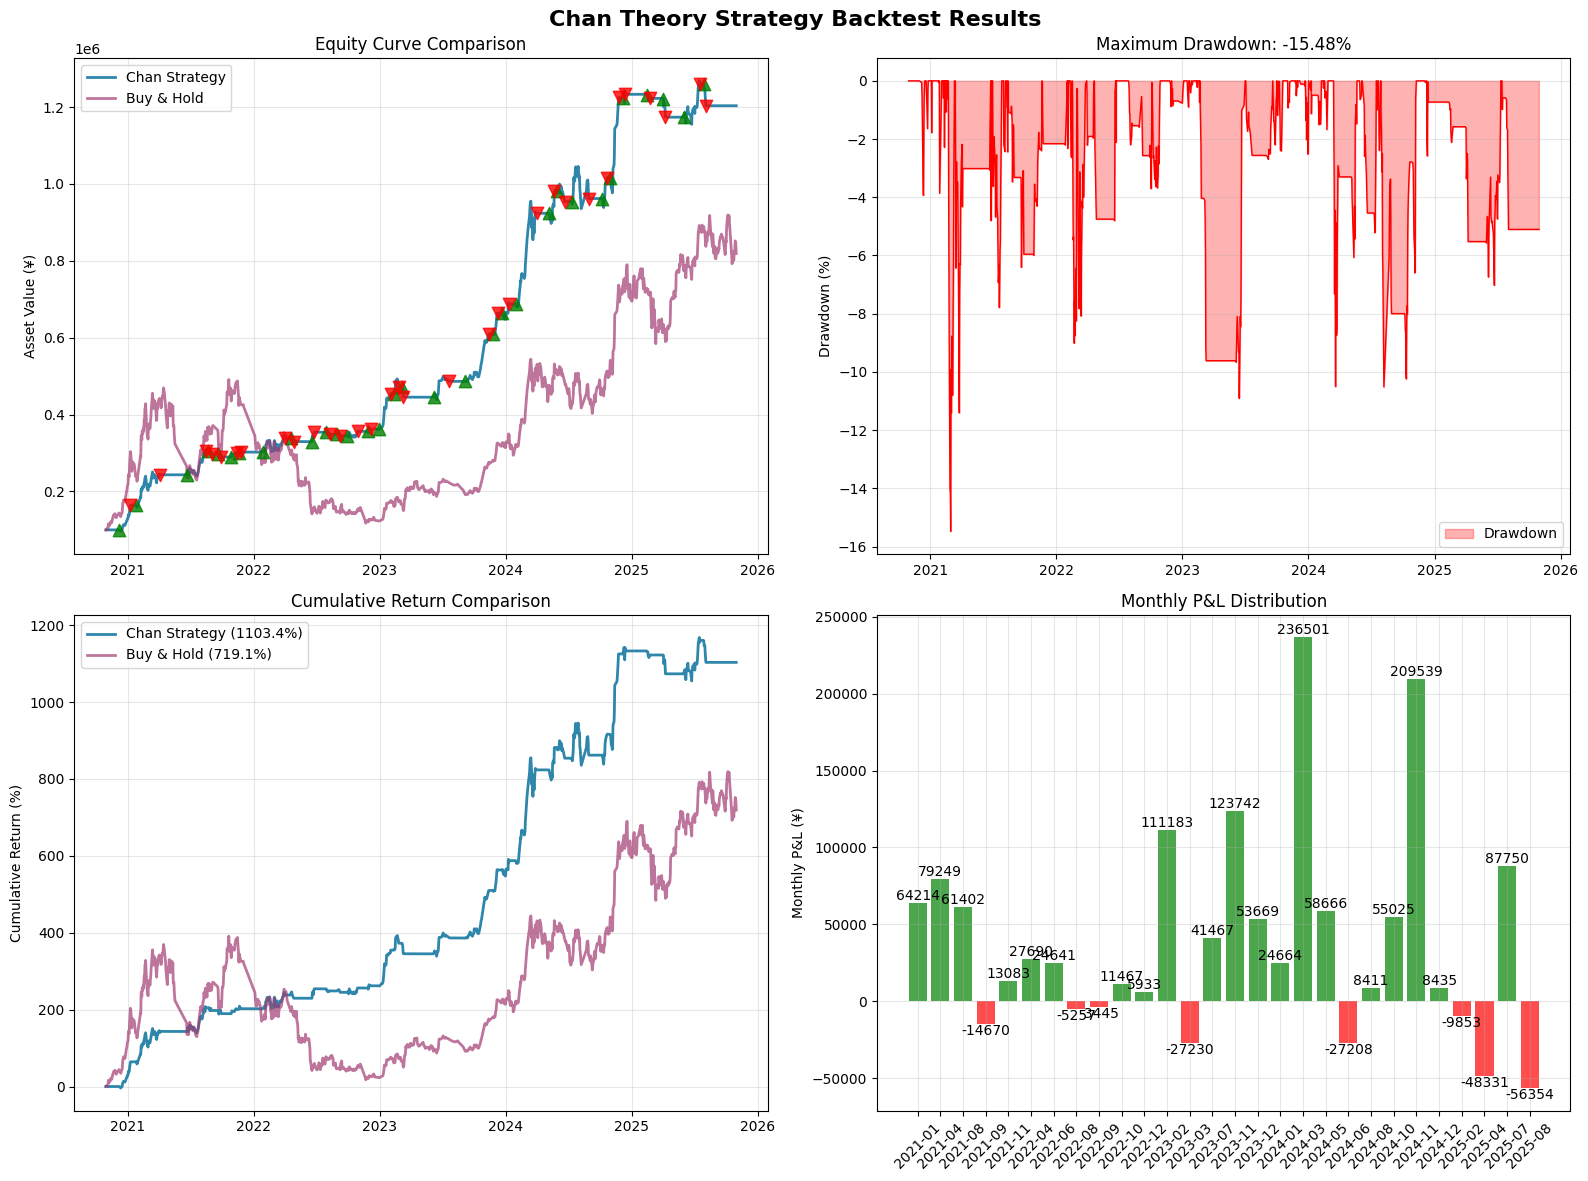

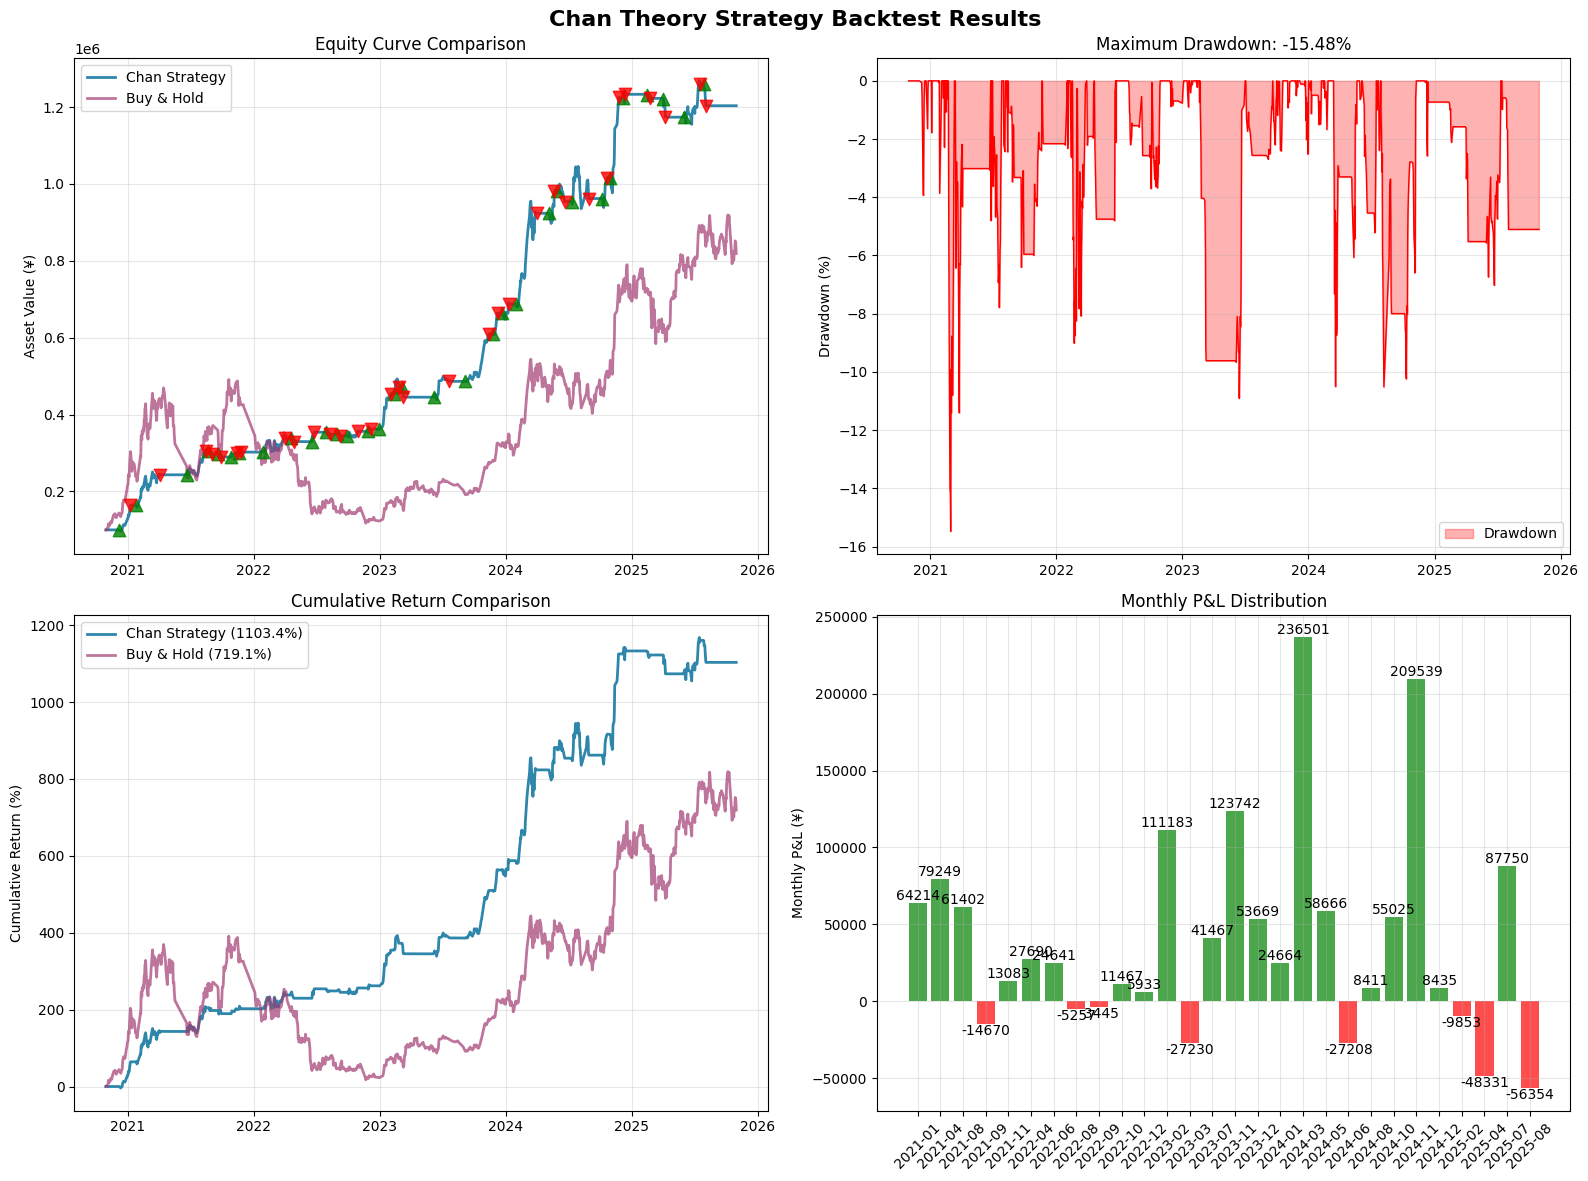

In [28]:
# Backtest results visualization
def plot_backtest_results():
    # Prepare data
    equity_df = pd.DataFrame(equity_curve)
    equity_df['date'] = pd.to_datetime(equity_df['date'])
    
    # Calculate benchmark (buy and hold)
    initial_price = equity_df['price'].iloc[0]
    equity_df['buy_hold_value'] = (equity_df['price'] / initial_price) * backtester.initial_capital
    
    # Calculate drawdown
    peak = equity_df['total_value'].expanding().max()
    equity_df['drawdown'] = (equity_df['total_value'] - peak) / peak * 100
    
    # Create trade records DataFrame
    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df['date'] = pd.to_datetime(trades_df['date'])
    
    # Create charts
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Chan Theory Strategy Backtest Results', fontsize=16, fontweight='bold')
    
    # 1. Equity curve comparison
    ax1 = axes[0, 0]
    ax1.plot(equity_df['date'], equity_df['total_value'], 
             label='Chan Strategy', color='#2E86AB', linewidth=2)
    ax1.plot(equity_df['date'], equity_df['buy_hold_value'], 
             label='Buy & Hold', color='#A23B72', linewidth=2, alpha=0.7)
    
    # Mark buy/sell points
    if not trades_df.empty:
        buy_trades = trades_df[trades_df['action'] == 'buy']
        sell_trades = trades_df[trades_df['action'] == 'sell']
        
        for _, trade in buy_trades.iterrows():
            idx = equity_df[equity_df['date'] <= trade['date']].index[-1]
            ax1.scatter(trade['date'], equity_df.loc[idx, 'total_value'], 
                       color='green', marker='^', s=80, zorder=5, alpha=0.8)
        
        for _, trade in sell_trades.iterrows():
            idx = equity_df[equity_df['date'] <= trade['date']].index[-1]
            ax1.scatter(trade['date'], equity_df.loc[idx, 'total_value'], 
                       color='red', marker='v', s=80, zorder=5, alpha=0.8)
    
    ax1.set_title('Equity Curve Comparison')
    ax1.set_ylabel('Asset Value (¥)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Maximum drawdown
    ax2 = axes[0, 1]
    ax2.fill_between(equity_df['date'], equity_df['drawdown'], 0, 
                     color='red', alpha=0.3, label='Drawdown')
    ax2.plot(equity_df['date'], equity_df['drawdown'], color='red', linewidth=1)
    ax2.set_title(f'Maximum Drawdown: {stats["max_drawdown_pct"]:.2f}%')
    ax2.set_ylabel('Drawdown (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Cumulative return comparison
    ax3 = axes[1, 0]
    strategy_returns = (equity_df['total_value'] / backtester.initial_capital - 1) * 100
    buyhold_returns = (equity_df['buy_hold_value'] / backtester.initial_capital - 1) * 100
    
    ax3.plot(equity_df['date'], strategy_returns, 
             label=f'Chan Strategy ({strategy_returns.iloc[-1]:.1f}%)', 
             color='#2E86AB', linewidth=2)
    ax3.plot(equity_df['date'], buyhold_returns, 
             label=f'Buy & Hold ({buyhold_returns.iloc[-1]:.1f}%)', 
             color='#A23B72', linewidth=2, alpha=0.7)
    
    ax3.set_title('Cumulative Return Comparison')
    ax3.set_ylabel('Cumulative Return (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Monthly P&L distribution
    ax4 = axes[1, 1]
    if not trades_df.empty:
        monthly_profits = trades_df[trades_df['action'] == 'sell'].copy()
        if not monthly_profits.empty:
            monthly_profits['month'] = monthly_profits['date'].dt.to_period('M')
            monthly_summary = monthly_profits.groupby('month')['profit'].sum()
            
            colors = ['green' if x >= 0 else 'red' for x in monthly_summary.values]
            bars = ax4.bar(range(len(monthly_summary)), monthly_summary.values, 
                          color=colors, alpha=0.7)
            ax4.set_title('Monthly P&L Distribution')
            ax4.set_ylabel('Monthly P&L (¥)')
            ax4.set_xticks(range(len(monthly_summary)))
            ax4.set_xticklabels([str(m) for m in monthly_summary.index], rotation=45)
            
            # Add value labels
            for i, bar in enumerate(bars):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}', ha='center', va='bottom' if height >= 0 else 'top')
        else:
            ax4.text(0.5, 0.5, 'No complete trade records', ha='center', va='center', 
                    transform=ax4.transAxes, fontsize=14)
            ax4.set_title('Monthly P&L Distribution')
    else:
        ax4.text(0.5, 0.5, 'No trade records', ha='center', va='center', 
                transform=ax4.transAxes, fontsize=14)
        ax4.set_title('Monthly P&L Distribution')
    
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Generate visualization results
plot_backtest_results()

In [29]:
# Detailed trade analysis
def analyze_trades_detail():
    if not trades:
        print("No trade records available for analysis")
        return
    
    trades_df = pd.DataFrame(trades)
    trades_df['date'] = pd.to_datetime(trades_df['date'])
    
    print("\n=== Detailed Trade Analysis ===")
    
    # Analysis by trading pattern
    sell_trades = trades_df[trades_df['action'] == 'sell'].copy()
    if not sell_trades.empty:
        print("\nAnalysis by signal type:")
        pattern_stats = sell_trades.groupby('reason').agg({
            'profit': ['count', 'sum', 'mean'],
            'return_rate': 'mean'
        }).round(3)
        
        for pattern in pattern_stats.index:
            count = pattern_stats.loc[pattern, ('profit', 'count')]
            total_profit = pattern_stats.loc[pattern, ('profit', 'sum')]
            avg_profit = pattern_stats.loc[pattern, ('profit', 'mean')]
            avg_return = pattern_stats.loc[pattern, ('return_rate', 'mean')] * 100
            
            print(f"  {pattern}:")
            print(f"    Trade count: {count}")
            print(f"    Total P&L: ¥{total_profit:,.0f}")
            print(f"    Average P&L: ¥{avg_profit:,.0f}")
            print(f"    Average return: {avg_return:.2f}%")
    
    # Recent 10 trades
    print(f"\nRecent 10 trades detail:")
    recent_trades = trades_df.tail(10)[['date', 'action', 'price', 'reason', 'profit', 'return_rate']].copy()
    if 'profit' in recent_trades.columns:
        recent_trades['profit'] = recent_trades['profit'].fillna(0)
    if 'return_rate' in recent_trades.columns:
        recent_trades['return_rate'] = (recent_trades['return_rate'].fillna(0) * 100).round(2)
    
    for _, trade in recent_trades.iterrows():
        date_str = trade['date'].strftime('%Y-%m-%d') if pd.notna(trade['date']) else 'N/A'
        profit_str = f"¥{trade.get('profit', 0):,.0f}" if 'profit' in trade else "N/A"
        return_str = f"{trade.get('return_rate', 0):.2f}%" if 'return_rate' in trade else "N/A"
        
        print(f"  {date_str}: {trade['action']} @¥{trade['price']:.2f} "
              f"- {trade.get('reason', 'N/A')} - P&L:{profit_str} ({return_str})")

analyze_trades_detail()


=== Detailed Trade Analysis ===

Analysis by signal type:
  Stop loss (ATR-based):
    Trade count: 4
    Total P&L: ¥-159,122
    Average P&L: ¥-39,781
    Average return: -7.00%
  er_mai - Er mai: Pullback after yi mai did not make new high:
    Trade count: 1
    Total P&L: ¥-7,953
    Average P&L: ¥-7,953
    Average return: -4.60%
  san_mai - San mai: Pullback near lower edge did not strongly penetrate (dist 0.004):
    Trade count: 1
    Total P&L: ¥-9,853
    Average P&L: ¥-9,853
    Average return: -1.40%
  san_mai - San mai: Pullback near lower edge did not strongly penetrate (dist 0.028):
    Trade count: 1
    Total P&L: ¥5,933
    Average P&L: ¥5,933
    Average return: 3.00%
  yi_mai - Segment reversal yi mai:
    Trade count: 25
    Total P&L: ¥1,285,382
    Average P&L: ¥51,415
    Average return: 21.90%

Recent 10 trades detail:
  2024-12-05: buy @¥98741.54 - er_mai - Er mai: Pullback after yi mai did not make new low - P&L:¥0 (0.00%)
  2024-12-13: sell @¥100046.65 - y

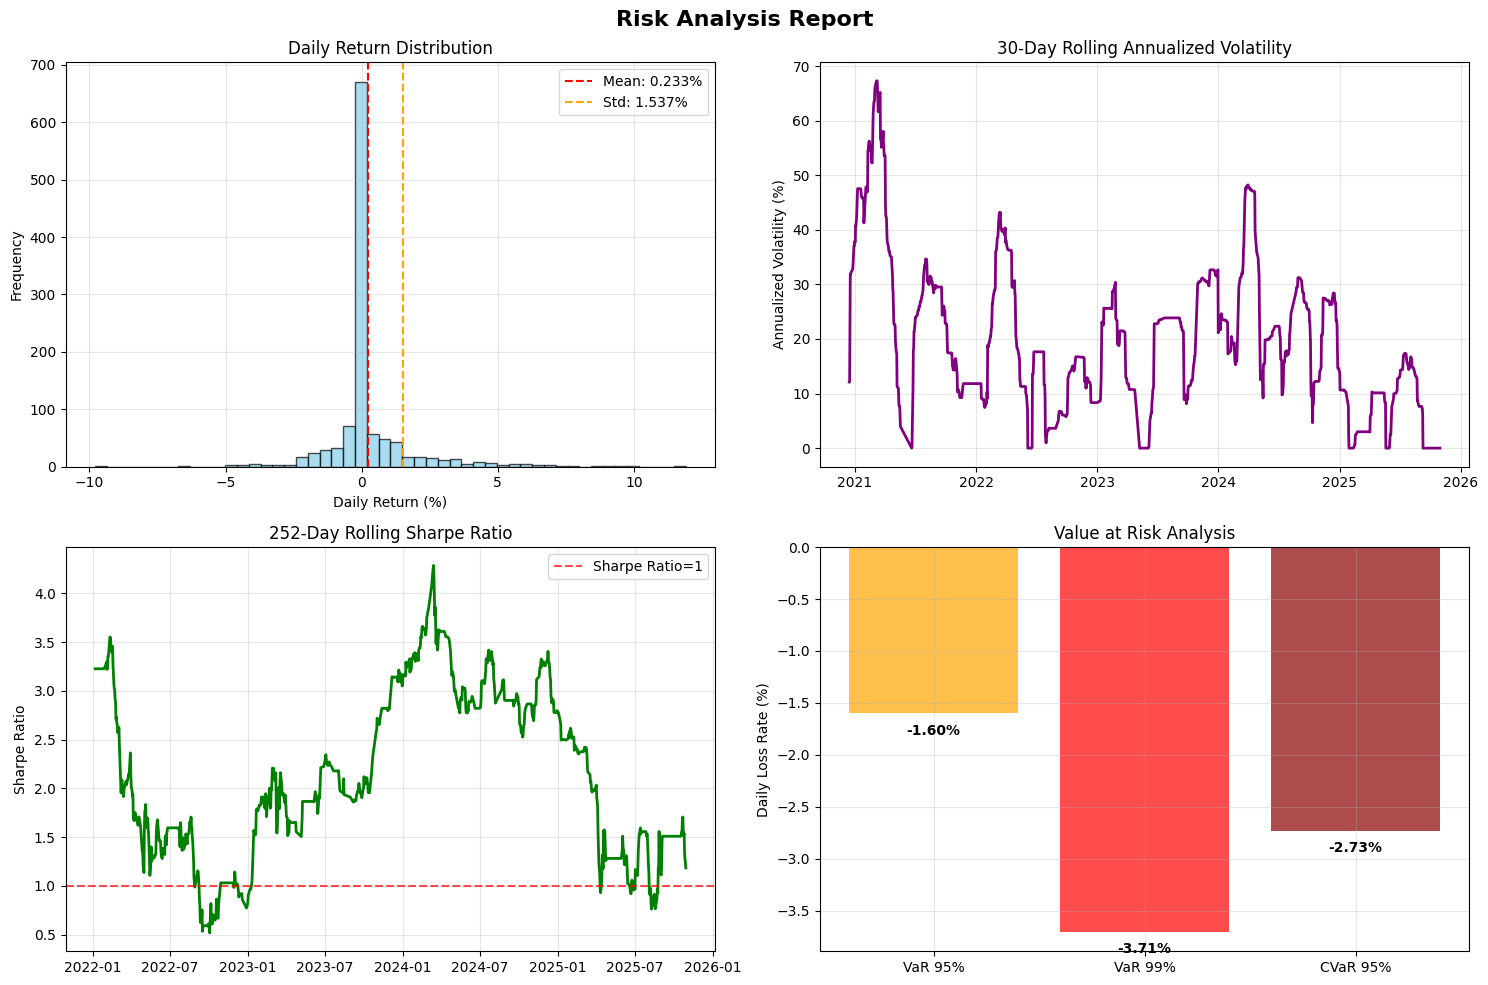


=== Risk Statistical Indicators ===
Daily return mean: 0.233%
Daily return std: 1.537%
Annualized volatility: 24.40%
Skewness: 1.863
Kurtosis: 12.394
VaR (95%): -1.60%
VaR (99%): -3.71%
CVaR (95%): -2.73%
Maximum consecutive losses: 2


In [30]:
# Risk indicator analysis
def plot_risk_analysis():
    equity_df = pd.DataFrame(equity_curve)
    equity_df['date'] = pd.to_datetime(equity_df['date'])
    
    # Calculate daily returns
    equity_df['daily_return'] = equity_df['total_value'].pct_change()
    daily_returns = equity_df['daily_return'].dropna()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Risk Analysis Report', fontsize=16, fontweight='bold')
    
    # 1. Daily return distribution
    ax1 = axes[0, 0]
    ax1.hist(daily_returns * 100, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(daily_returns.mean() * 100, color='red', linestyle='--', 
                label=f'Mean: {daily_returns.mean()*100:.3f}%')
    ax1.axvline(daily_returns.std() * 100, color='orange', linestyle='--', 
                label=f'Std: {daily_returns.std()*100:.3f}%')
    ax1.set_title('Daily Return Distribution')
    ax1.set_xlabel('Daily Return (%)')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Rolling volatility
    ax2 = axes[0, 1]
    rolling_vol = daily_returns.rolling(30).std() * np.sqrt(252) * 100
    ax2.plot(equity_df['date'][30:], rolling_vol[29:], color='purple', linewidth=2)
    ax2.set_title('30-Day Rolling Annualized Volatility')
    ax2.set_ylabel('Annualized Volatility (%)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Rolling Sharpe ratio
    ax3 = axes[1, 0]
    rolling_returns = daily_returns.rolling(252).mean() * 252  # Annualized return
    rolling_sharpe = (rolling_returns - 0.03) / (daily_returns.rolling(252).std() * np.sqrt(252))
    ax3.plot(equity_df['date'][252:], rolling_sharpe[251:], color='green', linewidth=2)
    ax3.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Sharpe Ratio=1')
    ax3.set_title('252-Day Rolling Sharpe Ratio')
    ax3.set_ylabel('Sharpe Ratio')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. VaR and CVaR analysis
    ax4 = axes[1, 1]
    var_95 = np.percentile(daily_returns, 5) * 100
    var_99 = np.percentile(daily_returns, 1) * 100
    cvar_95 = daily_returns[daily_returns <= np.percentile(daily_returns, 5)].mean() * 100
    
    ax4.bar(['VaR 95%', 'VaR 99%', 'CVaR 95%'], [var_95, var_99, cvar_95], 
            color=['orange', 'red', 'darkred'], alpha=0.7)
    ax4.set_title('Value at Risk Analysis')
    ax4.set_ylabel('Daily Loss Rate (%)')
    
    for i, v in enumerate([var_95, var_99, cvar_95]):
        ax4.text(i, v-0.1, f'{v:.2f}%', ha='center', va='top', fontweight='bold')
    
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print risk statistics
    print("\n=== Risk Statistical Indicators ===")
    print(f"Daily return mean: {daily_returns.mean()*100:.3f}%")
    print(f"Daily return std: {daily_returns.std()*100:.3f}%")
    print(f"Annualized volatility: {daily_returns.std()*np.sqrt(252)*100:.2f}%")
    print(f"Skewness: {daily_returns.skew():.3f}")
    print(f"Kurtosis: {daily_returns.kurtosis():.3f}")
    print(f"VaR (95%): {var_95:.2f}%")
    print(f"VaR (99%): {var_99:.2f}%")
    print(f"CVaR (95%): {cvar_95:.2f}%")
    
    # Calculate maximum consecutive losses
    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        sell_trades = trades_df[trades_df['action'] == 'sell'].copy()
        if not sell_trades.empty:
            profits = sell_trades['profit'].values
            max_consecutive_loss = 0
            current_loss_streak = 0
            
            for profit in profits:
                if profit < 0:
                    current_loss_streak += 1
                    max_consecutive_loss = max(max_consecutive_loss, current_loss_streak)
                else:
                    current_loss_streak = 0
            
            print(f"Maximum consecutive losses: {max_consecutive_loss}")

plot_risk_analysis()

In [32]:
# Investment Advice Analysis Based on Latest Indicators

# First, create the subset variables that were previously defined in the plot function
price_df = chan.comp_df.copy()
price_df['date'] = pd.to_datetime(price_df['date'])

# Use the same filtering logic as in the plot function
last_n = 60  # or whatever value you want to use for recent analysis
subset_df = price_df.tail(last_n)

low_i = subset_df['index'].min()
high_i = subset_df['index'].max()

# Helper function to filter objects by index range (copied from plot_util.py)
def _filter_by_index_range(price_df, items, key='index', low_i=None, high_i=None):
    if low_i is None or high_i is None:
        return items
    out = []
    for it in items:
        idx_val = it.get(key) if isinstance(it, dict) else None
        if idx_val is not None and low_i <= idx_val <= high_i:
            out.append(it)
    return out

# Create filtered versions of the data for the subset
strokes_sub = _filter_by_index_range(price_df, strokes, key='start_index', low_i=low_i, high_i=high_i)
zhongshu_sub = _filter_by_index_range(price_df, zhongshu, key='start_index', low_i=low_i, high_i=high_i)

def analyze_current_market_position():
    # Get latest data points
    latest_price = subset_df['close'].iloc[-1]
    latest_date = subset_df['date'].iloc[-1]
    latest_index = subset_df['index'].iloc[-1]
    
    print("=== CURRENT MARKET ANALYSIS ===")
    print(f"Latest Price: ${latest_price:.3f}")
    print(f"Analysis Date: {latest_date.strftime('%Y-%m-%d')}")
    print(f"Index Position: {latest_index}")

        
    current_zhongshu = zhongshu_sub[-1]  # Most recent zhongshu
    zs_upper = current_zhongshu['upper']
    zs_lower = current_zhongshu['lower']
    zs_center = current_zhongshu['center']
    
    print(f"\n=== KEY LEVELS ===")
    print(f"Current Zhongshu Range: ${zs_lower:.3f} - ${zs_upper:.3f}")
    print(f"Zhongshu Center: ${zs_center:.3f}")
    
    # Position relative to zhongshu
    if latest_price > zs_upper:
        zs_position = "ABOVE zhongshu - Strong bullish"
    elif latest_price < zs_lower:
        zs_position = "BELOW zhongshu - Strong bearish"
    else:
        zs_position = "WITHIN zhongshu - Consolidation"
    
    print(f"Price Position: {zs_position}")
    
    # Analyze recent strokes
    if len(strokes_sub) >= 3:
        recent_strokes = strokes_sub[-3:]  # Last 3 strokes
        stroke_directions = [s['direction'] for s in recent_strokes]
        
        print(f"\n=== STROKE ANALYSIS ===")
        print(f"Recent stroke pattern: {' -> '.join(stroke_directions)}")
        
        # Check for potential signals
        latest_stroke = strokes_sub[-1]
        stroke_strength = abs(latest_stroke['end_price'] - latest_stroke['start_price']) / latest_stroke['start_price']
        
        print(f"Latest stroke: {latest_stroke['direction']} ({stroke_strength:.2%} move)")
    else:
        print(f"\n=== STROKE ANALYSIS ===")
        print("Insufficient stroke data for analysis")
        latest_stroke = None
        stroke_strength = 0
    
    # Risk assessment using ATR
    current_atr = atr_map.get(latest_index, 0.02)
    print(f"Current ATR: {current_atr:.2%} (volatility measure)")
    
    # Generate recommendation
    print(f"\n=== INVESTMENT RECOMMENDATION ===")
    
    recommendation = "HOLD"
    confidence = 0.5
    risk_level = "MEDIUM"
    
    # Decision logic based on Chan Theory
    if latest_stroke and latest_price > zs_upper and latest_stroke['direction'] == 'up':
        if stroke_strength > 0.05:  # Strong upward move
            recommendation = "BUY"
            confidence = 0.75
            risk_level = "MEDIUM-HIGH"
        else:
            recommendation = "CAUTIOUS BUY"
            confidence = 0.6
    
    elif latest_stroke and latest_price < zs_lower and latest_stroke['direction'] == 'down':
        if stroke_strength > 0.05:  # Strong downward move
            recommendation = "SELL/AVOID"
            confidence = 0.75
            risk_level = "HIGH"
        else:
            recommendation = "WAIT"
            confidence = 0.6
    
    elif zs_lower <= latest_price <= zs_upper:
        if latest_stroke and latest_stroke['direction'] == 'up' and latest_price > zs_center:
            recommendation = "SMALL BUY"
            confidence = 0.55
        elif latest_stroke and latest_stroke['direction'] == 'down' and latest_price < zs_center:
            recommendation = "REDUCE POSITION"
            confidence = 0.55
    
    # Adjust for high volatility
    if current_atr > 0.03:
        risk_level = "HIGH"
        if "BUY" in recommendation:
            recommendation = f"CAUTIOUS {recommendation}"
    
    print(f"Recommendation: {recommendation}")
    print(f"Confidence Level: {confidence:.0%}")
    print(f"Risk Level: {risk_level}")
    
    # Entry/Exit levels
    if "BUY" in recommendation:
        entry_level = latest_price
        stop_loss = max(zs_lower, latest_price * (1 - current_atr * 2))
        take_profit = latest_price * (1 + current_atr * 3)
        
        print(f"\n=== TRADING LEVELS ===")
        print(f"Entry Level: ${entry_level:.3f}")
        print(f"Stop Loss: ${stop_loss:.3f} ({((stop_loss/entry_level-1)*100):+.1f}%)")
        print(f"Take Profit: ${take_profit:.3f} ({((take_profit/entry_level-1)*100):+.1f}%)")
        
    elif "SELL" in recommendation or "REDUCE" in recommendation:
        exit_level = latest_price
        reentry_level = zs_lower * 0.98
        
        print(f"\n=== TRADING LEVELS ===")
        print(f"Exit Level: ${exit_level:.3f}")
        print(f"Re-entry Level: ${reentry_level:.3f}")
    
    # Risk management advice
    print(f"\n=== RISK MANAGEMENT ===")
    print(f"Position Size: Due to {risk_level} risk, consider {'20-30%' if risk_level == 'HIGH' else '40-60%' if risk_level == 'MEDIUM-HIGH' else '60-80%'} of normal position")
    print(f"Time Horizon: {'Short-term (1-2 weeks)' if current_atr > 0.025 else 'Medium-term (1-2 months)'}")
    
    # Market context
    print(f"\n=== MARKET CONTEXT ===")
    recent_performance = (latest_price / subset_df['close'].iloc[0] - 1) * 100
    print(f"Recent Performance: {recent_performance:+.1f}% over last {len(subset_df)} periods")
    
    return {
        'recommendation': recommendation,
        'confidence': confidence,
        'risk_level': risk_level,
        'entry_price': latest_price,
        'key_levels': {
            'zs_upper': zs_upper,
            'zs_lower': zs_lower,
            'zs_center': zs_center
        }
    }

# Execute analysis
advice = analyze_current_market_position()

=== CURRENT MARKET ANALYSIS ===
Latest Price: $110066.000
Analysis Date: 2025-10-30
Index Position: 1826

=== KEY LEVELS ===
Current Zhongshu Range: $108713.398 - $113996.344
Zhongshu Center: $111354.871
Price Position: WITHIN zhongshu - Consolidation

=== STROKE ANALYSIS ===
Recent stroke pattern: down -> up -> up
Latest stroke: up (8.89% move)
Current ATR: 4.14% (volatility measure)

=== INVESTMENT RECOMMENDATION ===
Recommendation: HOLD
Confidence Level: 50%
Risk Level: HIGH

=== RISK MANAGEMENT ===
Position Size: Due to HIGH risk, consider 20-30% of normal position
Time Horizon: Short-term (1-2 weeks)

=== MARKET CONTEXT ===
Recent Performance: -3.6% over last 60 periods
